Xử lý dữ liệu, ghép từ 2 nguồn Phishtank URL Phishing và Kaggle URL Benign

In [25]:
%pip install pandas
%pip install matplotlib
%pip install wordcloud
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [10]:
# Đọc file
df = pd.read_csv("../Data/verified_online.csv")

# Tạo dataframe mới chỉ gồm 3 cột theo yêu cầu
df_new = pd.DataFrame()
df_new["url"] = df["url"]
df_new["label"] = "phishing"     # gán nhãn cố định
df_new["result"] = 1             # gán kết quả cố định

# Lưu ra file mới
df_new.to_csv("../Data/phishing_processed.csv", index=False)

print(df_new.head())

                                                 url     label  result
0                         https://accoun.obkcbcp.top  phishing       1
1  https://access-rogersclient.im/pages/?d=rogers...  phishing       1
2  https://ipfs.io/ipfs/bafkreicbfraar7276wutlutl...  phishing       1
3                 https://metamsk-login.created.app/  phishing       1
4                     https://metalogln.created.app/  phishing       1


In [20]:
import pandas as pd

# Đọc file 2
df2 = pd.read_csv("../Data/urldata.csv")

# Xoá toàn bộ hàng có label = "malicious"
df2_clean = df2[df2["label"] != "malicious"]

# Lưu lại file đã làm sạch (tuỳ chọn)
df2_clean.to_csv("../Data/benign.csv", index=False)

print("Số hàng bị xoá:", len(df2) - len(df2_clean))
print("Done! Đã tạo file file2_clean.csv")


Số hàng bị xoá: 104438
Done! Đã tạo file file2_clean.csv


In [32]:
df1 = pd.read_csv("../Data/phishing_processed.csv")
df2 = pd.read_csv("../Data/benign.csv")
df2 = df2.iloc[:, 1:] 
# Merge theo kiểu nối hàng
df_merged = pd.concat([df1, df2], ignore_index=True)

# Lưu file sau khi merge
df_merged.to_csv("../Data/merged.csv", index=False)

print(df_merged.shape)
print(df_merged.head())


(392623, 3)
                                                 url     label  result
0                         https://accoun.obkcbcp.top  phishing       1
1  https://access-rogersclient.im/pages/?d=rogers...  phishing       1
2  https://ipfs.io/ipfs/bafkreicbfraar7276wutlutl...  phishing       1
3                 https://metamsk-login.created.app/  phishing       1
4                     https://metalogln.created.app/  phishing       1


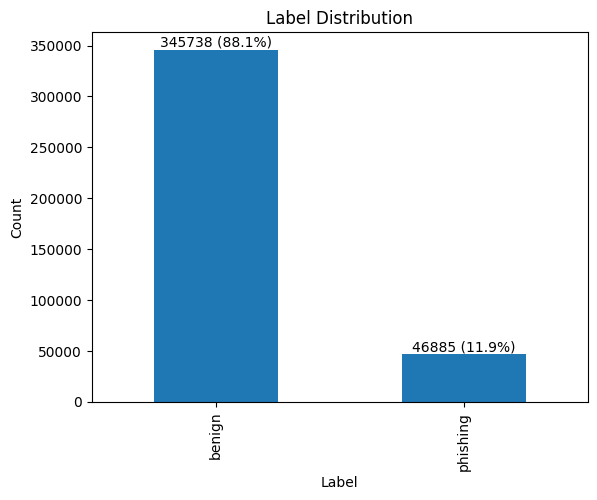

In [31]:
df = pd.read_csv("../Data/merged.csv")

# Đếm số lượng theo label
counts = df["label"].value_counts()
total = counts.sum()

# Vẽ chart
ax = counts.plot(kind="bar")

plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

# Thêm số lượng và % trên từng cột
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    
    ax.annotate(
        f"{count} ({percent:.1f}%)",                    # text hiển thị
        (p.get_x() + p.get_width() / 2, p.get_height()), # vị trí
        ha='center', va='bottom', fontsize=10
    )

plt.show()

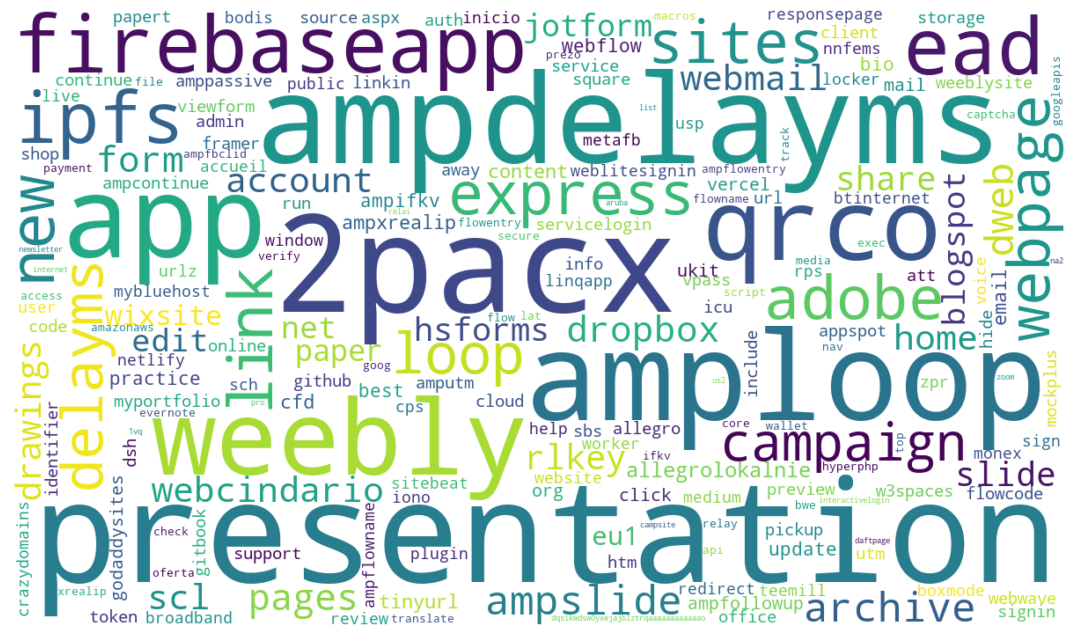

Done. Saved phishing_wordcloud_cleaned.png


In [30]:
import pandas as pd
from urllib.parse import urlparse, unquote
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- config ---
INPUT = "../Data/merged.csv"
LABEL = "phishing"
MAX_WORDS = 200
MIN_WORD_LEN = 3

# stopwords bổ sung (mở rộng nếu cần)
extra_stopwords = {
    "https","http","www","com","html","php","amp","id","doc","docs","google",
    "start","true","false","login","index","page","view","site","web","www2",
    "pub","bit","ly","dev","www1","www3"
}

# --- helper functions ---
def extract_tokens_from_url(url):
    """
    Trả về list token có ý nghĩa từ domain + path + (optionally) filename.
    """
    if not isinstance(url, str) or url.strip()=="":
        return []
    # decode percent-encoding
    url = unquote(url)
    # ensure has scheme for urlparse
    if not re.match(r'^[a-zA-Z]+://', url):
        url = "http://" + url
    try:
        p = urlparse(url)
    except Exception:
        return []
    tokens = []
    # domain tokens: break by dots and hyphens
    domain = p.netloc.lower()
    # remove port
    domain = re.sub(r':\d+$','', domain)
    domain = domain.replace("www.", "")
    domain_parts = re.split(r'[\.\-]+', domain)
    tokens.extend(domain_parts)
    # path tokens: split by slash, dash, underscore, dot and non-alnum
    path = p.path.lower()
    path_parts = re.split(r'[\/\-\_\.\?\=\&\%]+', path)
    tokens.extend(path_parts)
    # query keys & values optionally
    query = p.query.lower()
    if query:
        qparts = re.split(r'[\/\-\_\.\?\=\&\%]+', query)
        tokens.extend(qparts)
    # clean tokens: only alpha-numeric, remove empty
    cleaned = []
    for t in tokens:
        t = re.sub(r'[^a-z0-9]', '', t)
        if t and len(t) >= MIN_WORD_LEN:
            cleaned.append(t)
    return cleaned

# --- main ---
df = pd.read_csv(INPUT)

# lọc nhãn phishing
df_phishing = df[df["label"] == LABEL].copy()

# build token list
all_tokens = []
for url in df_phishing["url"].astype(str):
    toks = extract_tokens_from_url(url)
    # loại stopwords
    toks = [t for t in toks if t not in extra_stopwords]
    all_tokens.extend(toks)

# join thành text
text = " ".join(all_tokens)

# nếu muốn loại các token quá phổ biến (ví dụ top k) bạn có thể:
# from collections import Counter
# c = Counter(all_tokens)
# too_common = {w for w,n in c.most_common(10)}
# text = " ".join([t for t in all_tokens if t not in too_common])

# tạo wordcloud
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    max_words=MAX_WORDS,
    collocations=False  # tránh ghép 2 từ vô nghĩa
).generate(text)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# (tùy chọn) lưu ảnh
wc.to_file("../Data/phishing_wordcloud_cleaned.png")
print("Done. Saved phishing_wordcloud_cleaned.png")
